# Extend Janus-CT To Identify Bugs in the Quantum Circuit

**Author:** Congliang Lang \& Siwei Tan  

**Date:** 8/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom

The vectorization of Janus-CT can be extended to more downstream tasks. For example, in this notebook, we use Janus-CT to identify the potential bugs in the quantum algorithm implementation. We apply a data driven method that traing a model to predict the error rate 

In [1]:
import sys
sys.path.append('..')
import os
os.chdir("..")
import logging
logging.basicConfig(level=logging.WARN)
import ray
ray.init(log_to_driver=False)
from janusq.data_objects.algorithms import get_algs
import random
import seaborn as sns
import numpy as np
from collections import defaultdict
import pandas as pd
import jax.numpy as jnp
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.baselines.fidelity_prediction.rb_prediction import RBModel
from janusq.simulator.gate_error_model import GateErrorModel

from janusq.analysis.vectorization import RandomwalkModel
from janusq.data_objects.circuit import Gate
from janusq.data_objects.backend import GridBackend

from janusq.simulator.noisy_simulator import NoisySimulator
from janusq.dataset import load_dataset
from janusq.tools.ray_func import map
from janusq.data_objects.backend import LinearBackend
from janusq.data_objects.circuit import SeperatableCircuit
import copy


2024-04-15 03:05:52,813	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67096576 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-04-15 03:05:53,978	INFO worker.py:1724 -- Started a local Ray instance.


In [2]:
algs = ['qft', 'hs', 'ising', 'qknn', 'qsvm', 'vqc', 'ghz', 'grover']

In [3]:
# TODO: 跑不通，scan少个参数，ray跑不动
import statistics


def scan(n_qubits, n_steps, n_walks, n_bugs):
    
    
    backend = LinearBackend(n_qubits)

    dataset =  get_algs(n_qubits, backend, algs)

    id2circuit = {
        circuit.name: circuit
        for circuit in dataset
    }

    vec_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
    vecs_per_circuit = vec_model.train(dataset, True, remove_redundancy = False, return_value = True)
    # [(n_gates, max_table_size), (a, max_table_size), (b, max_table_size).....]

    total_vecs = np.vstack(vecs_per_circuit)
    vecs_from = np.hstack( [np.ones(len(vecs), dtype=int) * i for i, vecs in enumerate(vecs_per_circuit)] )

    
    alg2success_num, alg2bug_num, alg2error_num, alg2identify_num = defaultdict(int), defaultdict(int),defaultdict(int),defaultdict(int)


    def find_bug(bug_circuit, bug_gate_ids):  # bug_instructions是正样本
        
        alg_name = bug_circuit.name
        # n_qubits = bug_circuit.n_qubits
        gate_vecs = vec_model.vectorize(bug_circuit)
        
    

        each_gate2nearest_circuits = []

        
        for analyzed_vec in gate_vecs:
            
            dists =  np.sqrt( np.sum(  (total_vecs - analyzed_vec)**2, axis=1 ))
            
            dist_indices = np.argsort(dists)[:3]  
            nearest_dists = dists[dist_indices]
            
            dist_indices = dist_indices[nearest_dists < 10] # TODO experimental
            nearest_dists = dists[dist_indices]
            
           
            nearest_circuits = vecs_from[dist_indices]
            nearest_circuits = set(nearest_circuits.tolist())
            each_gate2nearest_circuits.append(nearest_circuits)
            


        for bug_gate_idx, nearest_circuits in enumerate(each_gate2nearest_circuits):

            neighbor_nearest_circuits = []
            for nearest_circuit_set in each_gate2nearest_circuits[bug_gate_idx-6:bug_gate_idx] + each_gate2nearest_circuits[bug_gate_idx+1: bug_gate_idx+6]: 
                neighbor_nearest_circuits += list(nearest_circuit_set)
            

            neighbor_mode_nearest_circuit1 = None
            neighbor_mode_nearest_circuit2 = None
            if len(neighbor_nearest_circuits) > 0:
                neighbor_mode_nearest_circuit1 = statistics.mode(neighbor_nearest_circuits)
                neighbor_nearest_circuits = [elm for elm in neighbor_nearest_circuits if elm != neighbor_mode_nearest_circuit1]
                if len(neighbor_nearest_circuits) > 0:
                    neighbor_mode_nearest_circuit2 = statistics.mode(neighbor_nearest_circuits)


            if neighbor_mode_nearest_circuit1 not in nearest_circuits:
                if neighbor_mode_nearest_circuit2 is None:
                    if bug_gate_idx not in bug_gate_ids:
                        alg2error_num[alg_name] += 1
                elif neighbor_mode_nearest_circuit2 not in nearest_circuits:
                    if bug_gate_idx not in bug_gate_ids:
                        alg2error_num[alg_name] += 1
                # else:
                #     success_num += 1
                    
            alg2identify_num[alg_name] += 1

        
        alg2bug_num[alg_name] += len(bug_gate_ids)
        for bug_gate_idx in bug_gate_ids:
            if alg_name not in [algs[i] for i in each_gate2nearest_circuits[bug_gate_idx]]:
                alg2success_num[alg_name] += 1

    def construct_negative(circuit, bug_num):
        bug_circuit = copy.deepcopy(circuit)

        bug_start = random.randint(0, max(circuit.n_gates - 1 - bug_num, 1))
        bug_end = bug_start + bug_num
        bug_gate_ids = list(range(bug_start, min(bug_end, circuit.n_gates)))

        for bug_gate_id in bug_gate_ids:
            
            gate = bug_circuit.gates[bug_gate_id]

            name = random.choice(backend.basis_gates) # ['rx', 'ry', 'rz', 'h', 'cz', 'cx']

            params = np.random.random((3,1)) * 2 * np.pi
            params = params.tolist()
            
            qubit1 = random.randint(0, n_qubits - 1)
            qubit2 = random.choice([qubit for qubit in range(n_qubits) if qubit != qubit1])
            qubits = [qubit1, qubit2]
            
            gate['name'] = name
            if name in ('rx', 'ry', 'rz'):
                gate['qubits'] = qubits[:1]
                gate['params'] = params[:1]
                
            elif name in ('cz', 'cx'):
                gate['qubits'] = qubits
                gate['params'] = []
                
            elif name in ('h'):
                gate['qubits'] = qubits[:1]
                gate['params'] = []
                
            elif name in ('u'):
                gate['qubits'] = qubits[:1]
                gate['params'] = params
                
            else:
                logging.error("no such gate")
                return circuit

        bug_circuit.name = bug_circuit.name
        return bug_circuit, bug_gate_ids


    def bug_detect(alg_name, n_qubits):
        circuit_id = f'{alg_name}_{n_qubits}'

        current_circuit = id2circuit[circuit_id]
        bug_circuit, bug_gate_ids = construct_negative(current_circuit, bug_num = n_bugs) 

        find_bug(bug_circuit, bug_gate_ids)


    for alg_name in algs:
        bug_detect(alg_name, n_qubits)


    print('bug_size', n_bugs)
    print('alg2success_num=', alg2success_num)
    print('alg2bug_num=', alg2bug_num)
    print('alg2error_num=', alg2error_num)
    print('alg2identify_num=', alg2identify_num)
    
    return alg2success_num, alg2bug_num, alg2error_num, alg2identify_num


In [4]:

@ray.remote(max_calls=6)
def scan_remote(n_qubits, n_steps, n_walks, n_bugs):
    return scan(n_qubits, n_steps, n_walks, n_bugs)

In [5]:
results = {}
qubit_range = list(range(5,8))
for n_qubits in qubit_range:
    for n_steps in range(2, 5):
        n_walks = n_steps * 16
        for n_bugs in range(1, 4):
            key = (n_qubits, n_steps, n_walks, n_bugs)
            
            future = scan_remote.remote(*key)
            results[key] = future

In [6]:
for key, future in results.items():
    result = ray.get(results[key])
    results[key] = result

In [7]:
results

{(5,
  2,
  32,
  1): (defaultdict(int,
              {'qft_5': 1,
               'hs_5': 1,
               'ising_5': 1,
               'qknn_5': 1,
               'qsvm_5': 1,
               'vqc_5': 1,
               'ghz_5': 1,
               'grover_5': 1}), defaultdict(int,
              {'qft_5': 1,
               'hs_5': 1,
               'ising_5': 1,
               'qknn_5': 1,
               'qsvm_5': 1,
               'vqc_5': 1,
               'ghz_5': 1,
               'grover_5': 1}), defaultdict(int,
              {'qft_5': 1, 'qknn_5': 1}), defaultdict(int,
              {'qft_5': 115,
               'hs_5': 17,
               'ising_5': 29,
               'qknn_5': 63,
               'qsvm_5': 34,
               'vqc_5': 436,
               'ghz_5': 5,
               'grover_5': 237})),
 (5,
  2,
  32,
  2): (defaultdict(int,
              {'qft_5': 2,
               'hs_5': 2,
               'ising_5': 2,
               'qknn_5': 2,
               'qsvm_5': 2,
      

In [8]:
alg2n_qubit2success_num = defaultdict(lambda: defaultdict(int))
alg2n_qubit2bug_num = defaultdict(lambda: defaultdict(int))


for key, result in results.items():
    n_qubits, n_steps, n_walks, n_bugs = key

    for alg_name in algs:
        alg_name = f'{alg_name}_{n_qubits}'
        alg2n_qubit2success_num[alg_name][n_qubits] += result[0][alg_name]

    for alg_name in algs:
        alg_name = f'{alg_name}_{n_qubits}'
        alg2n_qubit2bug_num[alg_name][n_qubits] += result[1][alg_name]
            


In [9]:
def combine(dict1, dict2, default_value = 1):
    all_values = []
    new_dict = defaultdict(lambda: defaultdict(lambda: default_value))
    for k1, v1 in dict1.items():
        for k2, v2 in v1.items():
            new_dict[k1][k2] = v2 / dict2[k1][k2]
            all_values.append(v2 / dict2[k1][k2])
    
    return new_dict, np.array(all_values)

In [10]:
alg2n_qubit2success_rate, all_values = combine(alg2n_qubit2success_num, alg2n_qubit2bug_num)
alg2n_qubit2success_rate, np.mean(all_values)

(defaultdict(<function __main__.combine.<locals>.<lambda>()>,
             {'qft_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 1.0}),
              'hs_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 1.0}),
              'ising_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 1.0}),
              'qknn_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 1.0}),
              'qsvm_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 1.0}),
              'vqc_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 1.0}),
              'ghz_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,

TODO: 找到最大的step

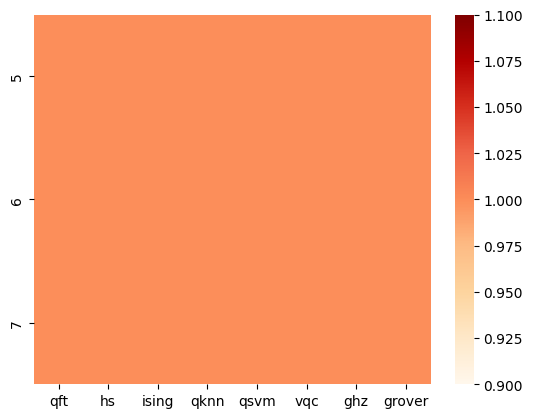

In [11]:
data = np.zeros((len(qubit_range) , len(algs))) # 先index, 后column

for r_i, n_qubits in enumerate(qubit_range):
    for c_i, alg_name in enumerate(algs):
        alg_name = f'{alg_name}_{n_qubits}'
        data[r_i][c_i] = alg2n_qubit2success_rate[alg_name][n_qubits]

df = pd.DataFrame(data, index=qubit_range, columns=algs)
fig = sns.heatmap(data=df,cmap='OrRd')

In [12]:
alg2n_qubit2error_num = defaultdict(lambda: defaultdict(int))
alg2n_qubit2identify_num = defaultdict(lambda: defaultdict(int))

for key, result in results.items():
    n_qubits, n_steps, n_walks, n_bugs = key


    for alg_name in algs:
        alg_name = f'{alg_name}_{n_qubits}'
        alg2n_qubit2error_num[alg_name][n_qubits] += result[2][alg_name]

    for alg_name in algs:
        alg_name = f'{alg_name}_{n_qubits}'
        alg2n_qubit2identify_num[alg_name][n_qubits] += result[3][alg_name]
        

In [13]:
alg2n_qubit2error_rate, all_values = combine(alg2n_qubit2error_num, alg2n_qubit2identify_num, 0)
alg2n_qubit2error_rate, np.mean(all_values)

(defaultdict(<function __main__.combine.<locals>.<lambda>()>,
             {'qft_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 0.013565891472868217}),
              'hs_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 0.006535947712418301}),
              'ising_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 0.0}),
              'qknn_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 0.01763668430335097}),
              'qsvm_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 0.0215633423180593}),
              'vqc_5': defaultdict(<function __main__.combine.<locals>.<lambda>.<locals>.<lambda>()>,
                          {5: 0.0010224948875255625}),
              'ghz

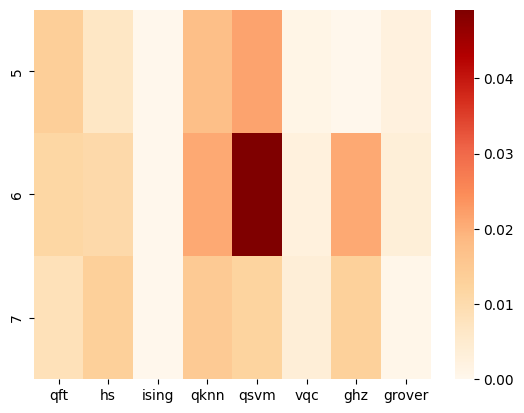

In [16]:
data = np.zeros((len(qubit_range) , len(algs))) # 先index, 后column

for r_i, n_qubits in enumerate(qubit_range):
    for c_i, alg_name in enumerate(algs):
        alg_name = f'{alg_name}_{n_qubits}'
        data[r_i][c_i] = alg2n_qubit2error_rate[alg_name][n_qubits]

df = pd.DataFrame(data, index=qubit_range, columns=algs)
fig = sns.heatmap(data=df,cmap='OrRd')